In [1]:
with open('sequences20') as handle:
    u = handle.read()
import json
seqs_by_length = json.loads(u)

In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# The matrix for an EVEN LENGTH R-L sequence
def cf2matrix(a):
    u = np.eye(2, dtype=np.int64)
    for x in a:
        u = np.matmul(u, [[x, 1], [1, 0]])
    return u

# The matrix for an even or odd length sequence, where the odd case is just the "condensed form" for an even sequence
def m_rep(seq):
    if len(seq) % 2 == 0:
        return cf2matrix(seq)
    else:
        return cf2matrix(seq + seq)
    
def rotl(x, k):
    return x[k:] + x[:k]

def min_rot(x):
    return min(rotl(x, k) for k in range(len(x)))

def min_rot2(x):
    return min(rotl(x, k) for k in range(0, len(x), 2))
    
def trace2length(t):
    return 2 * np.arccosh(t/2)

def length2trace(l):
    return 2 * np.cosh(l/2)

# The sequences that we actually want, from the "condensed forms" that take primitive roots in PGL_2(Z)
def actual_sequences(a, length):
    min_trace = int(length2trace(length)) + 1
    max_trace = int(length2trace(length+1)) + 1
    result = []
    for _x in a:
        x = _x[:] # Need this to make x harmlessly mutable
        m = m_rep(x)
        t = np.trace(m)
        if t < min_trace or t >= max_trace:
            x_length = trace2length(t)
            k = int((length + 1)/x_length)
            x *= k
        # Symmetrize by both R-L flip and time reversal, and add all four
        if len(x) % 2 == 0:
            result += [x, rotl(x, 1)]
        # Expand condensed form, and then symmetrize by time reversal
        else:
            xx = x + x
            result += [xx]
    return result

def my_actual_sequences(length):
    return actual_sequences(seqs_by_length[length], length)

def reduce_and_remove_duplicates(seqs):
    u = {tuple(min_rot2(x)) for x in seqs}
    return [list(x) for x in u if min_rot2(x[::-1]) != x]
            
def guys_for_trace(t):
    l = int(trace2length(t))
    l_seqs = my_actual_sequences(l)
    t_seqs = [x for x in l_seqs if np.trace(cf2matrix(x)) == t]
    return reduce_and_remove_duplicates(t_seqs)
    
def geos_in_trace_range(t0,t1):
    all_seqs = []
    for i in range(t0,t1+1):
        all_seqs += guys_for_trace(i)
    return all_seqs

In [4]:
def cfListToDicts(cfList):
    forwardDict = {}
    invDict = {}
    for cf in cfList:
        for obj in split(cf):
            if obj[0] in forwardDict:
                forwardDict[obj[0]].add(obj[1])
            else:
                forwardDict[obj[0]] = {obj[1]}
            if obj[1] in invDict:
                invDict[obj[1]].add(obj[0])
            else:
                invDict[obj[1]] = {obj[0]}
    return forwardDict,invDict

def permutationsOf(a):
    perms = []
    if len(a)%2==0:
        for n in range(0,len(a),2):
            perms.append(a[n:]+a[:n])
    else:
        for n in range(0,len(a)):
            perms.append(a[n:]+a[:n])
    return perms

def inv(lrSeq): #inverts a list of 0's and 1's (R's and L's)
    return tuple((np.array(lrSeq[::-1])-1)**2)

def split(contFrac): #splits a cont'd fraction on every possible pair of R's into 2 groups of R's and L's (in 0's and 1's)
    output = []
    converted = contFracToLR(contFrac)
    n = len(converted)
    splitPoints = pairs(converted)
    for i,j in splitPoints:
        temp = converted[i:]+converted[:i]
        temp1 = temp[1:(j-i)%n]
        temp2 = inv(temp[(j-i)%n+1:]) #inv(temp[(j-i)%n+1:])
        output.append((tuple(temp1),tuple(temp2)))
    return output

def contFracToLR(contFrac):
    if len(contFrac)%2==1:
        contFrac = contFrac + contFrac
    output = []
    for i in range(len(contFrac)):
        if i%2==1: #if original cont'd frac is even length, making last one R/alternating is same as this (hopefully)
            for j in range(contFrac[i]):
                output.append(1)
        else:
            for j in range(contFrac[i]):
                output.append(0)
    return output

def indices(lrSeq): #positions of R's (R=1)
    return [i for i in range(len(lrSeq)) if lrSeq[i]==1]

def pairs(lrSeq): #pairs of R's on which to split
    output = []
    for i in indices(lrSeq):
        for j in indices(lrSeq):
            if i==j:
                continue
            else:
                output.append((i,j))
    return output

def recover2(ls): #sends a whole list to a cont'd fraction (not clear whether this is needed)
    output = []
    i=0
    while i<len(ls):
        counter=1
        while(i<len(ls)-1 and ls[i] == ls[i+1]):
            i+=1
            counter+=1
        i+=1
        output.append(counter)
    if (len(output)%2!=0):
        output[len(output)-1]+=output[0]
        output = output[1:]
    return output

def pairToFrac(s1,s2):
    out = list(s1)+[1]+list(inv(s2))+[1]
    return tuple(min(permutationsOf(recover2(out))))

def getPants(cfList):
    dictPair = cfListToDicts(cfList)
    forwardDict = dictPair[0]
    invDict = dictPair[1]
    pants = set()
    for s0 in forwardDict:
        for s1 in forwardDict[s0]:
            if s1 in forwardDict and s0 in invDict:
                for s2 in forwardDict[s1].intersection(invDict[s0]):
                    y0,y1,y2 = pairToFrac(s0,s1),pairToFrac(s1,s2),pairToFrac(s2,s0)
                    if y0==y1 or y1==y2 or y0==y2:
                        continue
                    pants.add(frozenset((y0,y1,y2)))
    return pants

def pantsInTraceRange(traceMin,traceMax):
    cfList = []
    for trace in range(traceMin,traceMax+1):
        cfList += guys_for_trace(trace)
    return getPants(cfList)

def pantsInTraceRangeAndWithGivenCuff(traceMin,traceMax,cuttingSequence):
    allPants = pantsInTraceRange(traceMin,traceMax)
    pantsWithCuff = []
    for pants in allPants:
        if min(permutationsOf(cuttingSequence)) in pants:
            pantsWithCuff.append(pants)
    return pantsWithCuff

def boundaryCountForOrientedCuffs(traceMin,traceMax,cuttingSequencePositive): #i sort of screwed up orientation here
                                                                                #since surface is on the left and therefore
                                                                                #we prefer counterclockwise...
    cuttingSequenceNegative = cuttingSequencePositive[::-1]
    positiveOrientationPants = pantsInTraceRangeAndWithGivenCuff(traceMin,traceMax,cuttingSequencePositive)
    negativeOrientationPants = pantsInTraceRangeAndWithGivenCuff(traceMin,traceMax,cuttingSequenceNegative)
    return (len(positiveOrientationPants) - len(negativeOrientationPants))
            

def cfToMat(cf):
    mat = np.identity(2)
    length = 0
    for x in cf:
        mat = np.matmul(mat,[[x,1],[1,0]])
        length += 1
    if length % 2 == 1:
        mat = np.matmul(mat,mat)
    return np.array(mat).astype(int)


def pantsToGeodesics(pList):
    positives = list()
    for p in pList:
        for geo in p:
            minGeo = min(permutationsOf(geo))
            invGeo = min(permutationsOf(minGeo[::-1]))
            if minGeo in positives or invGeo in positives:
                continue
            else:
                positives.append(minGeo)
    return positives
                
def geosToEyes(geos):
    eyes = list()
    for geo in geos:
        for i in range(0,len(geo),2):
            a = list(geo[i:])+list(geo[:i])
            a = a[1:]
            a[0]-=1
            a[len(a)-1]-=1
            eyes.append((geo,tuple(a)))
    return eyes

def cuspInv(cusp):
    invCusp = list(cusp[::-1])
    if len(invCusp) == 1 and invCusp[0] <= 0:
        return tuple(invCusp)
    else:
        if invCusp[0] == 0:
            invCusp = invCusp[1:]
        else:
            invCusp = [0] + invCusp
        if invCusp[-1] == 0:
            invCusp = invCusp[:-1]
        else:
            invCusp = invCusp + [0]
        return tuple(invCusp)

def eyesToCusps(eList):
    output = list()
    for e in eList:
        eye = e[1]
        invEye = cuspInv(eye)
        if eye in output or invEye in output:
            continue
        else:
            output.append(eye)
    return output
                
def pantsAndEyesToMatrix(pantList, eyeList, posGeoList, posCuspList):
    
    geoIndexDict = {}
    cuspIndexDict = {}
    
    basisList = posGeoList + posCuspList
    
    for i in range(len(basisList)):
        if i < len(posGeoList):
            geoIndexDict[posGeoList[i]] = i 
        else:
            cuspIndexDict[posCuspList[i-len(posGeoList)]] = i
        
    colList = []
    for pants in pantList:
        col = np.zeros(len(basisList))
        for geo in pants:
            if geo in geoIndexDict:
                col[geoIndexDict[geo]] = 1
            else:
                col[geoIndexDict[min(permutationsOf(geo[::-1]))]] = -1
        colList.append(col)
    
    for eye in eyeList:
        col = np.zeros(len(basisList))
        
        if eye[0] in geoIndexDict:
            col[geoIndexDict[eye[0]]] = 1
        else:
            col[geoIndexDict[min(permutationsOf(eye[0][::-1]))]] = -1
        
        if eye[1] in cuspIndexDict:
            col[cuspIndexDict[eye[1]]] = 1
        else:
            col[cuspIndexDict[cuspInv(eye[1])]] = -1
        
        colList.append(col)
    
    return np.column_stack(colList)

In [5]:
pantsSet = pantsInTraceRange(180,200)

In [6]:
posGeoList = pantsToGeodesics(pantsSet)

In [7]:
eyeList = geosToEyes(posGeoList)

In [8]:
posCuspList = eyesToCusps(eyeList)

In [9]:
pantsList = list(pantsSet)

In [10]:
A = pantsAndEyesToMatrix(pantsList,eyeList,posGeoList,posCuspList)

In [11]:
A.shape

(1078, 2367)

P = (1,0)
pants sum: 578167.1069869308
avg pants cf: 377.39367296797053
eyes sum: 422217.308728333
avg eyes cf: 505.6494715309377
pants variance: 147891.16129137692
eyes variance: 1535235.6976820894


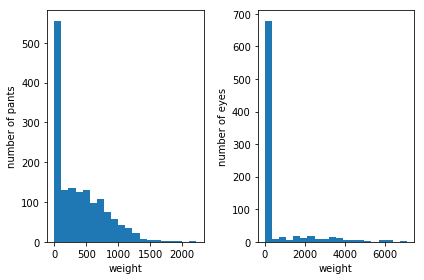

In [39]:
#cvxpy without integer constraints

import cvxpy as cp
weights  = (1,0)
resultList = pantsList+eyeList
P = np.diag([weights[0]]*len(pantsList) + [weights[1]]*len(eyeList))
# input
A = pantsAndEyesToMatrix(pantsList,eyeList,posGeoList,posCuspList)
b = np.zeros(A.shape[0])
# Construct a CVXPY problem
x = cp.Variable(A.shape[1],nonneg = True)
objective = cp.Minimize(cp.quad_form(x,P))
constraints = []
constraints.append(A@x==b)
constraints.append(cp.sum(x) == 10**6) #scaled solutions

prob = cp.Problem(objective,constraints)
prob.solve()
resultStr = ""
print(f"P = ({weights[0]},{weights[1]})")
print("pants sum: " + str(sum(x.value[:len(pantsList)])))
print("avg pants cf: " + str(sum(x.value[:len(pantsList)])/len(pantsList)))
print("eyes sum: " + str(sum(x.value[len(pantsList):])))
print("avg eyes cf: " + str(sum(x.value[len(pantsList):])/len(eyeList)))
print("pants variance: " + str(np.var(x.value[:len(pantsList)])))
print("eyes variance: " + str(np.var(x.value[len(pantsList):])))
n_bins = 20
fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].hist(x.value[:len(pantsList)], bins=n_bins)
axs[1].hist(x.value[len(pantsList):], bins=n_bins)
axs[0].set_ylabel('number of pants')
axs[1].set_ylabel('number of eyes')
axs[0].set_xlabel('weight')
axs[1].set_xlabel('weight')
solList = list(zip(resultList,x.value))
solList.sort(key=lambda x:x[1], reverse=True)
#for x in solList:
#    resultStr += "+" + str(x[1]) + "*" + str(x[0]) + "\n"
#print(resultStr)

trace range = (180, 200)
P = (1,1)
pants sum: 725911.7426830519
avg pants cf: 473.83273021086933
eyes sum: 274367.7283026633
avg eyes cf: 328.58410575169256
pants variance: 157186.33445205557
eyes variance: 583114.348310836


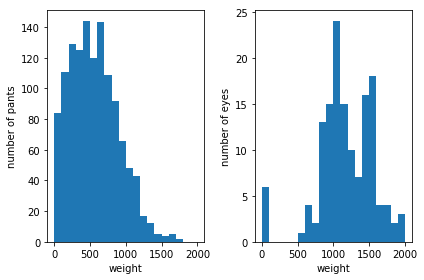

P = (1,2)
pants sum: 747083.1698276332
avg pants cf: 487.6521996263924
eyes sum: 253020.826521481
avg eyes cf: 303.0189539179413
pants variance: 174530.07289339733
eyes variance: 559168.1843949896


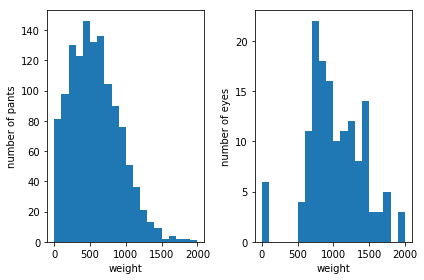

P = (1,4)
pants sum: 761720.1316613827
avg pants cf: 497.2063522593882
eyes sum: 238354.4944617873
avg eyes cf: 285.45448438537403
pants variance: 199800.64712791826
eyes variance: 546986.8818137241


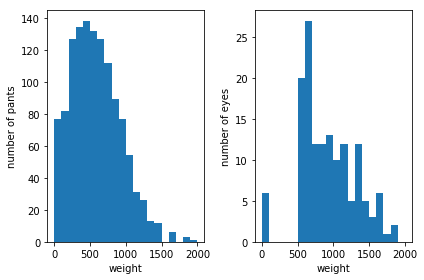

P = (1,8)
pants sum: 772112.550752333
avg pants cf: 503.9899156346821
eyes sum: 228007.73590284842
avg eyes cf: 273.06315676987833
pants variance: 258015.54404997893
eyes variance: 533492.5402343186


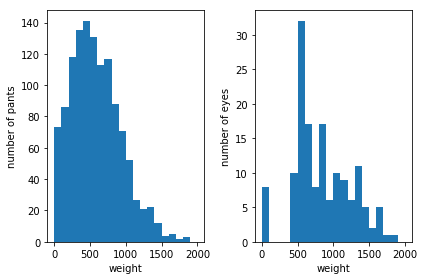

P = (1,16)
pants sum: 781484.9027137572
avg pants cf: 510.1076388471
eyes sum: 218691.3018937914
avg eyes cf: 261.90575077100766
pants variance: 446409.4077346526
eyes variance: 509297.8326739076


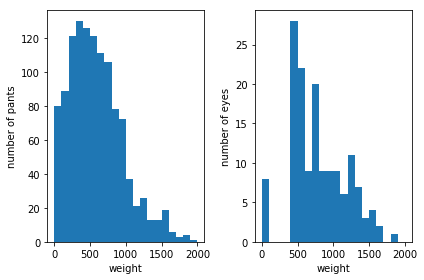

P = (1,32)
pants sum: 793002.7475591729
avg pants cf: 517.6258143336638
eyes sum: 207186.25857327896
avg eyes cf: 248.127255776382
pants variance: 1063475.994713375
eyes variance: 467896.592862921


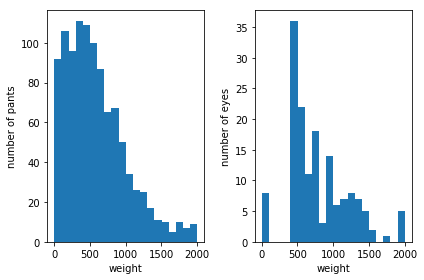

P = (1,64)
pants sum: 808475.4576850387
avg pants cf: 527.7254945724795
eyes sum: 191704.04344460717
avg eyes cf: 229.58568077198464
pants variance: 2772670.724527471
eyes variance: 408923.2652344848


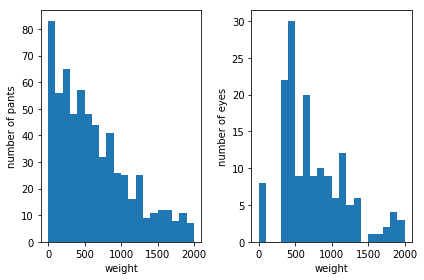

P = (1,128)
pants sum: 820697.7179876943
avg pants cf: 535.703471271341
eyes sum: 179458.90710306223
avg eyes cf: 214.92084683001465
pants variance: 4694649.796910222
eyes variance: 374101.0728008297


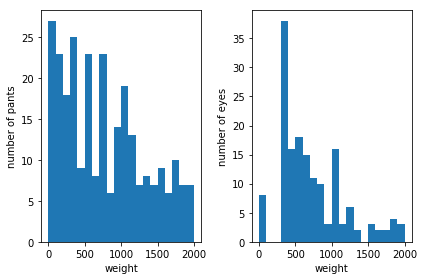

P = (1,256)
pants sum: 826002.517632964
avg pants cf: 539.1661342251723
eyes sum: 174128.8380721181
avg eyes cf: 208.5375306252911
pants variance: 5646531.311967255
eyes variance: 366561.1177524354


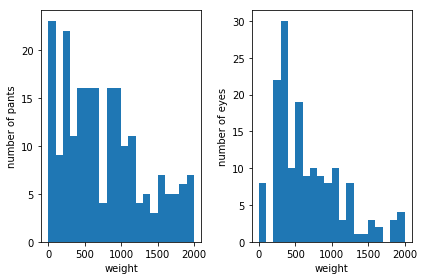

P = (1,512)
pants sum: 829049.2025508292
avg pants cf: 541.1548319522384
eyes sum: 171293.1642887543
avg eyes cf: 205.14151411826865
pants variance: 6431968.267493147
eyes variance: 362836.9922998311


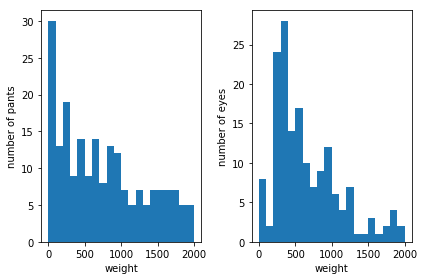

In [48]:
print("trace range = " + str((180,200)))
for c in range(10):
    weights  = (1,2**c)
    resultList = pantsList+eyeList
    P = np.diag([weights[0]]*len(pantsList) + [weights[1]]*len(eyeList))
    # input
    A = pantsAndEyesToMatrix(pantsList,eyeList,posGeoList,posCuspList)
    b = np.zeros(A.shape[0])
    # Construct a CVXPY problem
    x = cp.Variable(A.shape[1],nonneg = True)
    objective = cp.Minimize(cp.quad_form(x,P))
    constraints = []
    constraints.append(A@x==b)
    constraints.append(cp.sum(x) == 10**6) #scaled solutions

    prob = cp.Problem(objective,constraints)
    prob.solve()
    resultStr = ""
    print(f"P = ({weights[0]},{weights[1]})")
    print("pants sum: " + str(sum(x.value[:len(pantsList)])))
    print("avg pants cf: " + str(sum(x.value[:len(pantsList)])/len(pantsList)))
    print("eyes sum: " + str(sum(x.value[len(pantsList):])))
    print("avg eyes cf: " + str(sum(x.value[len(pantsList):])/len(eyeList)))
    print("pants variance: " + str(np.var(x.value[:len(pantsList)])))
    print("eyes variance: " + str(np.var(x.value[len(pantsList):])))
    n_bins = 20
    fig, axs = plt.subplots(1, 2, tight_layout=True)
    axs[0].hist(x.value[:len(pantsList)], bins=n_bins, range = (1,2000))
    axs[1].hist(x.value[len(pantsList):], bins=n_bins, range = (1,2000))
    axs[0].set_ylabel('number of pants')
    axs[1].set_ylabel('number of eyes')
    axs[0].set_xlabel('weight')
    axs[1].set_xlabel('weight')
    plt.show()
    solList = list(zip(resultList,x.value))
    solList.sort(key=lambda x:x[1], reverse=True)
    #for x in solList:
    #    resultStr += "+" + str(x[1]) + "*" + str(x[0]) + "\n"
    #print(resultStr)

In [49]:
pantsSet = pantsInTraceRange(200,220)

In [51]:
posGeoList = pantsToGeodesics(pantsSet)
eyeList = geosToEyes(posGeoList)
posCuspList = eyesToCusps(eyeList)
pantsList = list(pantsSet)
A = pantsAndEyesToMatrix(pantsList,eyeList,posGeoList,posCuspList)
A.shape

(1178, 2574)

trace range = (200, 220)
P = (1,1)
pants sum: 705144.8552507572
avg pants cf: 423.7649370497339
eyes sum: 295276.54252383433
avg eyes cf: 324.4797170591586
pants variance: 162288.20100395448
eyes variance: 566204.6150618944


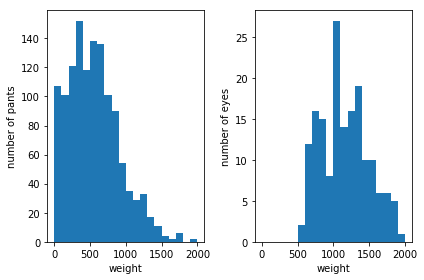

P = (1,2)
pants sum: 722027.4482811952
avg pants cf: 433.910726130526
eyes sum: 278366.8891559625
avg eyes cf: 305.89768039116757
pants variance: 174981.81319073215
eyes variance: 549789.6130546712


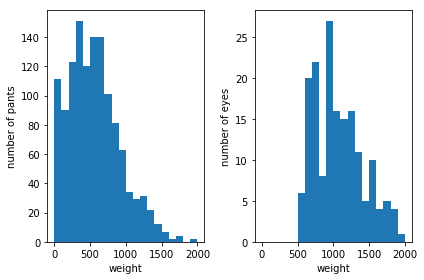

P = (1,4)
pants sum: 733860.9745320611
avg pants cf: 441.02222027167136
eyes sum: 266471.12250136904
avg eyes cf: 292.82540934216377
pants variance: 192306.28184540194
eyes variance: 542288.9188050928


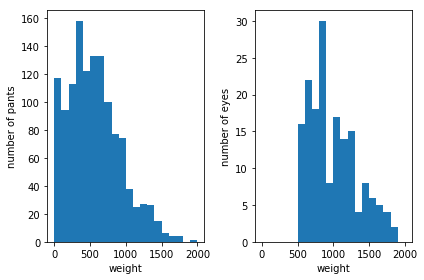

P = (1,8)
pants sum: 741920.5475157177
avg pants cf: 445.86571365127264
eyes sum: 258357.64611586978
avg eyes cf: 283.90950122623053
pants variance: 229122.1377191749
eyes variance: 534593.0577935923


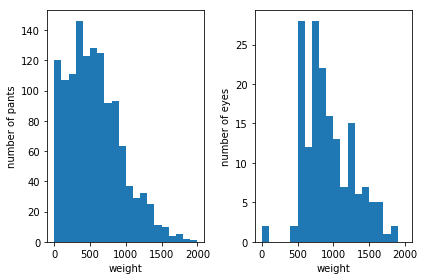

P = (1,16)
pants sum: 748742.0851573981
avg pants cf: 449.9651954070902
eyes sum: 251433.2628260468
avg eyes cf: 276.3002888198316
pants variance: 338866.7757066686
eyes variance: 521346.32082734857


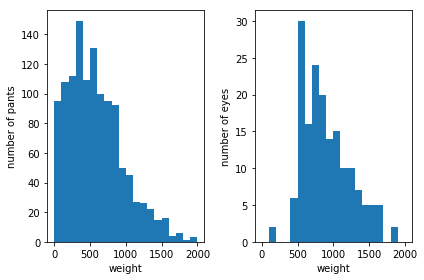

P = (1,32)
pants sum: 756877.4257609161
avg pants cf: 454.854222212089
eyes sum: 243300.3203729427
avg eyes cf: 267.3629894208161
pants variance: 717121.0422275772
eyes variance: 496811.21029613575


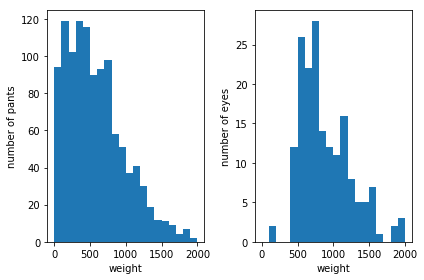

P = (1,64)
pants sum: 768591.1296686357
avg pants cf: 461.89370773355506
eyes sum: 231588.74069253696
avg eyes cf: 254.4931216401505
pants variance: 1927632.3575791551
eyes variance: 456369.97331387183


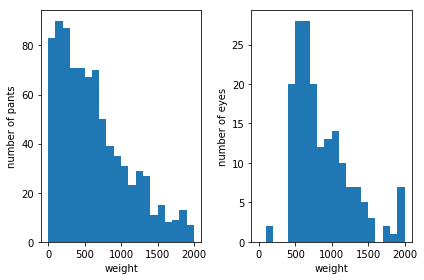

P = (1,128)
pants sum: 781777.235500797
avg pants cf: 469.81805018076744
eyes sum: 218409.6709036049
avg eyes cf: 240.0106273665988
pants variance: 3983538.3779046936
eyes variance: 420488.27538686874


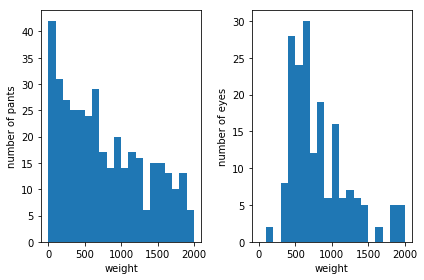

P = (1,256)
pants sum: 790103.9695485022
avg pants cf: 474.82209708443645
eyes sum: 210088.59161285442
avg eyes cf: 230.86658418994992
pants variance: 5424230.95402738
eyes variance: 409612.23431170144


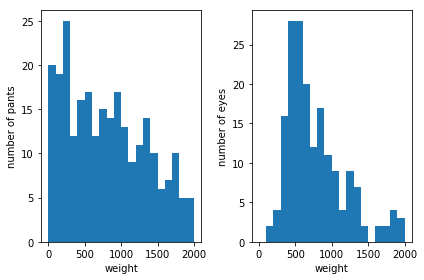

P = (1,512)
pants sum: 794766.1872011558
avg pants cf: 477.62391057761766
eyes sum: 205449.82851495582
avg eyes cf: 225.76904232412727
pants variance: 6445536.206198103
eyes variance: 406577.86743733025


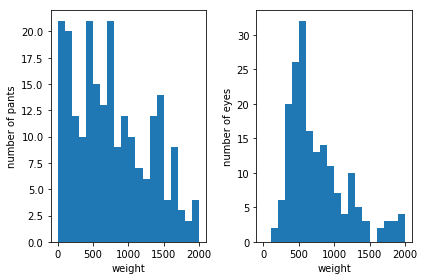

In [52]:
print("trace range = " + str((200,220)))
for c in range(10):
    weights  = (1,2**c)
    resultList = pantsList+eyeList
    P = np.diag([weights[0]]*len(pantsList) + [weights[1]]*len(eyeList))
    # input
    A = pantsAndEyesToMatrix(pantsList,eyeList,posGeoList,posCuspList)
    b = np.zeros(A.shape[0])
    # Construct a CVXPY problem
    x = cp.Variable(A.shape[1],nonneg = True)
    objective = cp.Minimize(cp.quad_form(x,P))
    constraints = []
    constraints.append(A@x==b)
    constraints.append(cp.sum(x) == 10**6) #scaled solutions

    prob = cp.Problem(objective,constraints)
    prob.solve()
    resultStr = ""
    print(f"P = ({weights[0]},{weights[1]})")
    print("pants sum: " + str(sum(x.value[:len(pantsList)])))
    print("avg pants cf: " + str(sum(x.value[:len(pantsList)])/len(pantsList)))
    print("eyes sum: " + str(sum(x.value[len(pantsList):])))
    print("avg eyes cf: " + str(sum(x.value[len(pantsList):])/len(eyeList)))
    print("pants variance: " + str(np.var(x.value[:len(pantsList)])))
    print("eyes variance: " + str(np.var(x.value[len(pantsList):])))
    n_bins = 20
    fig, axs = plt.subplots(1, 2, tight_layout=True)
    axs[0].hist(x.value[:len(pantsList)], bins=n_bins, range = (1,2000))
    axs[1].hist(x.value[len(pantsList):], bins=n_bins, range = (1,2000))
    axs[0].set_ylabel('number of pants')
    axs[1].set_ylabel('number of eyes')
    axs[0].set_xlabel('weight')
    axs[1].set_xlabel('weight')
    plt.show()
    solList = list(zip(resultList,x.value))
    solList.sort(key=lambda x:x[1], reverse=True)
    #for x in solList:
    #    resultStr += "+" + str(x[1]) + "*" + str(x[0]) + "\n"
    #print(resultStr)

In [53]:
pantsSet = pantsInTraceRange(220,250)
posGeoList = pantsToGeodesics(pantsSet)
eyeList = geosToEyes(posGeoList)
posCuspList = eyesToCusps(eyeList)
pantsList = list(pantsSet)
A = pantsAndEyesToMatrix(pantsList,eyeList,posGeoList,posCuspList)
A.shape

(1996, 7244)

trace range = (220, 250)
P = (1,1)
pants sum: 722761.9480075587
avg pants cf: 127.38137962769804
eyes sum: 279078.46345322276
avg eyes cf: 177.7569830912247
pants variance: 6364.27492564831
eyes variance: 178421.4238333656


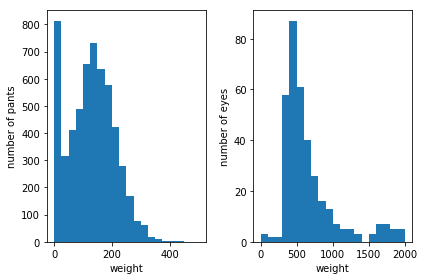

P = (1,2)
pants sum: 731772.6322942335
avg pants cf: 128.96944524043593
eyes sum: 270082.77608874306
avg eyes cf: 172.02724591639685
pants variance: 6473.482541365233
eyes variance: 179048.53675497064


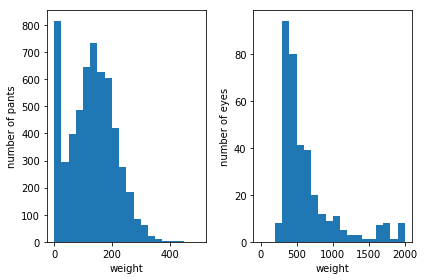

P = (1,4)
pants sum: 736528.1590821706
avg pants cf: 129.80757121645587
eyes sum: 265219.08559755253
avg eyes cf: 168.92935388379144
pants variance: 6565.676908931901
eyes variance: 179712.17470838001


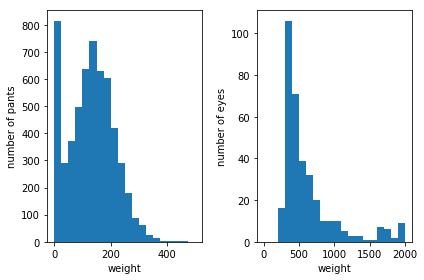

P = (1,8)
pants sum: 738984.6559423218
avg pants cf: 130.24051038814272
eyes sum: 262696.3425110414
avg eyes cf: 167.32251115352955
pants variance: 6616.674071256316
eyes variance: 180149.22964402038


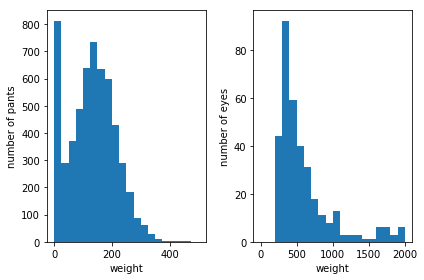

P = (1,16)
pants sum: 740268.458055902
avg pants cf: 130.4667708945897
eyes sum: 261399.952850003
avg eyes cf: 166.49678525477898
pants variance: 6638.298281872235
eyes variance: 180398.20029706415


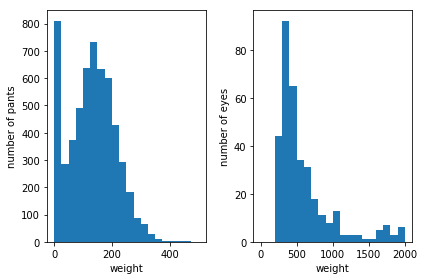

P = (1,32)
pants sum: 740926.3684427718
avg pants cf: 130.58272267232496
eyes sum: 260731.0084944011
avg eyes cf: 166.07070604738922
pants variance: 6647.587282241625
eyes variance: 180533.8451522753


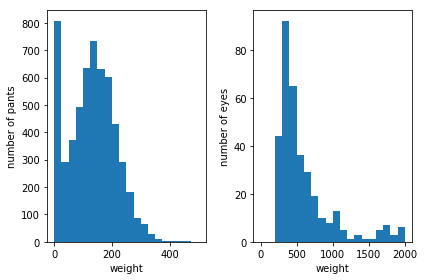

P = (1,64)
pants sum: 741257.408323252
avg pants cf: 130.64106597166938
eyes sum: 260391.1821461294
avg eyes cf: 165.85425614403147
pants variance: 6652.342815754079
eyes variance: 180604.55280104064


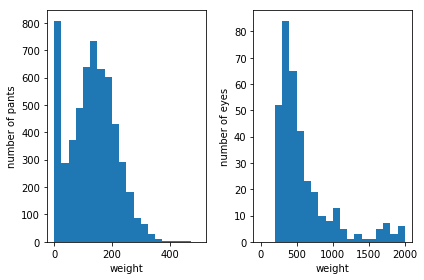

P = (1,128)
pants sum: 741423.1717210696
avg pants cf: 130.67028052891604
eyes sum: 260228.52625193907
avg eyes cf: 165.75065366365547
pants variance: 6654.446456202298
eyes variance: 180638.22844315387


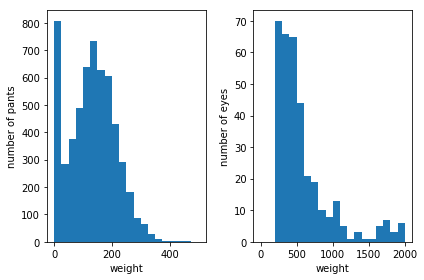

P = (1,256)
pants sum: 741506.1621146357
avg pants cf: 130.68490696415856
eyes sum: 260146.6859511213
avg eyes cf: 165.69852608351675
pants variance: 6655.516682543381
eyes variance: 180655.3001416554


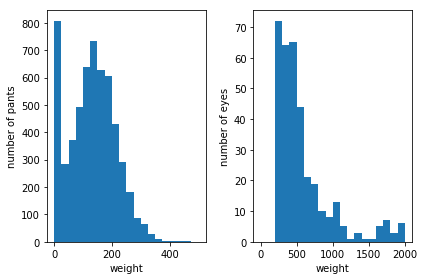

P = (1,512)
pants sum: 741547.693748532
avg pants cf: 130.6922266035481
eyes sum: 260105.17112530928
avg eyes cf: 165.67208351930526
pants variance: 6656.074269029199
eyes variance: 180664.02401932978


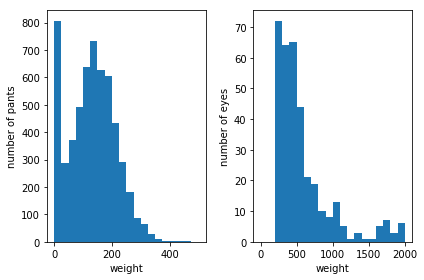

In [59]:
print("trace range = " + str((220,250)))
for c in range(10):
    weights  = (1,2**c)
    resultList = pantsList+eyeList
    P = np.diag([weights[0]]*len(pantsList) + [weights[1]]*len(eyeList))
    # input
    A = pantsAndEyesToMatrix(pantsList,eyeList,posGeoList,posCuspList)
    b = np.zeros(A.shape[0])
    # Construct a CVXPY problem
    x = cp.Variable(A.shape[1],nonneg = True)
    objective = cp.Minimize(cp.quad_form(x,P))
    constraints = []
    constraints.append(A@x==b)
    constraints.append(cp.sum(x) == 10**6) #scaled solutions

    prob = cp.Problem(objective,constraints)
    prob.solve()
    resultStr = ""
    print(f"P = ({weights[0]},{weights[1]})")
    print("pants sum: " + str(sum(x.value[:len(pantsList)])))
    print("avg pants cf: " + str(sum(x.value[:len(pantsList)])/len(pantsList)))
    print("eyes sum: " + str(sum(x.value[len(pantsList):])))
    print("avg eyes cf: " + str(sum(x.value[len(pantsList):])/len(eyeList)))
    print("pants variance: " + str(np.var(x.value[:len(pantsList)])))
    print("eyes variance: " + str(np.var(x.value[len(pantsList):])))
    n_bins = 20
    fig, axs = plt.subplots(1, 2, tight_layout=True)
    axs[0].hist(x.value[:len(pantsList)], bins=n_bins, range = (0,500))
    axs[1].hist(x.value[len(pantsList):], bins=n_bins, range = (1,2000))
    axs[0].set_ylabel('number of pants')
    axs[1].set_ylabel('number of eyes')
    axs[0].set_xlabel('weight')
    axs[1].set_xlabel('weight')
    plt.show()
    solList = list(zip(resultList,x.value))
    solList.sort(key=lambda x:x[1], reverse=True)
    #for x in solList:
    #    resultStr += "+" + str(x[1]) + "*" + str(x[0]) + "\n"
    #print(resultStr)